## A Problem that stumped Milton Friedman

(and that Abraham Wald solved by inventing sequential analysis)

#### By [Chase Coleman](https://github.com/cc7768) and [Thomas J. Sargent](http://www.tomsargent.com/), edited by [Alberto Polo](https://github.com/albep) 

We begin by importing some packages called by the code that we will be using in this notebook.

In [1]:
using Distributions
using QuantEcon.compute_fixed_point, QuantEcon.DiscreteRV, QuantEcon.draw, QuantEcon.LinInterp
using Plots
using LaTeXStrings

### Sequential analysis

Key ideas in  play are:

 * Bayes' Law
 
 * Dynamic programming

 * type I and type II statistical errors
    
    * a type I error occurs when you reject a  null hypothesis that is true
    
    * a type II error is when you accept a null hypothesis that is false 
 

 * Abraham Wald's **sequential probability ratio test**
 
 * The **power** of a statistical test
 
 * The **critical region** of a statistical test
 
 * A **uniformly most powerful test**


On pages 137-139 of his book **Two Lucky People** with Rose Friedman, Milton Friedman described a problem presented to him and Allen Wallis during World War II when they worked at the U.S. government's Statistical Research Group at Columbia University.  

Let's listen to Milton Friedman tell what happened.

   "In order to understand the story, it is necessary to have an idea of a simple statistical problem, and of the
   standard procedure for dealing with it.  The actual problem out of which sequential analysis grew will serve.
   The Navy has two alternative designs (say A and B) for a projectile.  It wants to determine which is superior. 
   To do so it undertakes a series of paired firings. On each round it assigns the value 1 or 0 to A accordingly as
   its performance is superior or inferio to that of B and conversely 0 or 1 to B.  The Navy asks the statistician 
   how to conduct the test and how to analyze the results. 
   
   "The standard statistical answer was to specify a number of firings (say 1,000) and a pair of percentages
   (e.g., 53% and 47%) and tell the client that if A receives a 1 in more than 53% of the firings, it can be regarded
   as superior; if it receives a 1 in fewer than 47%, B can be regarded as superior; if the percentage is between
   47% and 53%, neither can be so regarded.
   
   "When Allen Wallis was discussing such a problem with (Navy) Captain Garret L. Schyler, the captain objected that     such a test, to quote from Allen's account, may prove wasteful.  If a wise and seasoned ordnance officer like   Schyler were on the premises, he would see after the first few thousand or even few hundred [rounds] that the   experiment need not be completed either because he new method is obviously inferior or because it is obviously   superior beyond what was hoped for $\ldots$ "
  
  Friedman and Wallis struggled with the problem but after realizing that they were not able to solve it themselves told Abraham Wald it.  That started  Wald on the path that led  *Sequential Analysis*. We'll formulate the problem using dynamic programming.

This started Wald on the path that led him to _Sequential Analysis_

## Dynamic programming formulation


The following presentation of the problem closely follows Dmitri Berskekas's treatment in **Dynamic Programming and Stochastic Control**.  

An i.i.d.  random variable $z$ can take on values 

  * $z \in [ v_1,  v_2, \ldots,  v_n]$ when $z$ is a discrete-valued random variable
  
  * $ z \in V$ when $z$ is a continuous random variable.  

A decision maker wants to  know which of two probability distributions governs  $z$. To formalize this idea,
let $x \in [x_0, x_1]$ be a hidden state that indexes the two distributions:

$$ P(v_k \mid x) = \begin{cases} f_0(v_k) & \mbox{if } x = x_0, \\
                              f_1(v_k) & \mbox{if } x = x_1. \end{cases} $$
                              
when $z$ is a discrete random variable and a density


$$ P(v \mid x) = \begin{cases} f_0(v) & \mbox{if } x = x_0, \\
                              f_1(v) & \mbox{if } x = x_1. \end{cases} $$
                              
when $v$ is continuously distributed.                              

                              

Before observing any outcomes, a decision maker believes that the probability that $x = x_0$ is $p_{-1}\in (0,1)$: 

$$ p_{-1} = \textrm{Prob}(x=x_0 \mid \textrm{ no observations}) $$

After observing $k+1$ observations $z_k, z_{k-1}, \ldots, z_0$ he believes that the probability that the distribution is $f_0$ is

$$ p_k = {\rm Prob} ( x = x_0 \mid z_k, z_{k-1}, \ldots, z_0) $$

We can compute this $p_k$ recursively by applying Bayes' law:

$$ p_0 = \frac{ p_{-1} f_0(z_0)}{ p_{-1} f_0(z_0) + (1-p_{-1}) f_1(z_0) } $$

and then

$$ p_{k+1} = \frac{ p_k f_0(z_{k+1})}{ p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1}) }. $$


After observing $z_k, z_{k-1}, \ldots, z_0$, the decision maker believes that $z_{k+1}$ 
has probability distribution

$$ p(z_{k+1}) = p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1}). $$

This is evidently a mixture of distributions $f_0$ and $f_1$, with the weight on $f_0$ being the posterior probability $f_0$ that the distribution is $f_0$. 

**Remark:** *Because the decision maker believes that $z_{k+1}$ is drawn from a mixture of two i.i.d. distributions, he does *not* believe that the sequence  $[z_{k+1}, z_{k+2}, \ldots] $ is i.i.d.  Instead, he believes that it is *exchangeable*.  See David Kreps
*Notes on the Theory of Choice*, chapter 11, for a discussion.*

Let's look at some examples of two distributions. Here we'll display two beta distributions.  First, we'll show the two distributions, then we'll show mixtures of these same two distributions with various mixing probabilities $p_k$.

In [2]:
# Create two distributions over 50 values for k
# We are using a discretized beta distribution

p_m1 = linspace(0, 1, 50)
f0 = clamp(pdf(Beta(1, 1), p_m1), 1e-8, Inf)
f0 = f0 / sum(f0)
f1 = clamp(pdf(Beta(9, 9), p_m1), 1e-8, Inf)
f1 = f1 / sum(f1);


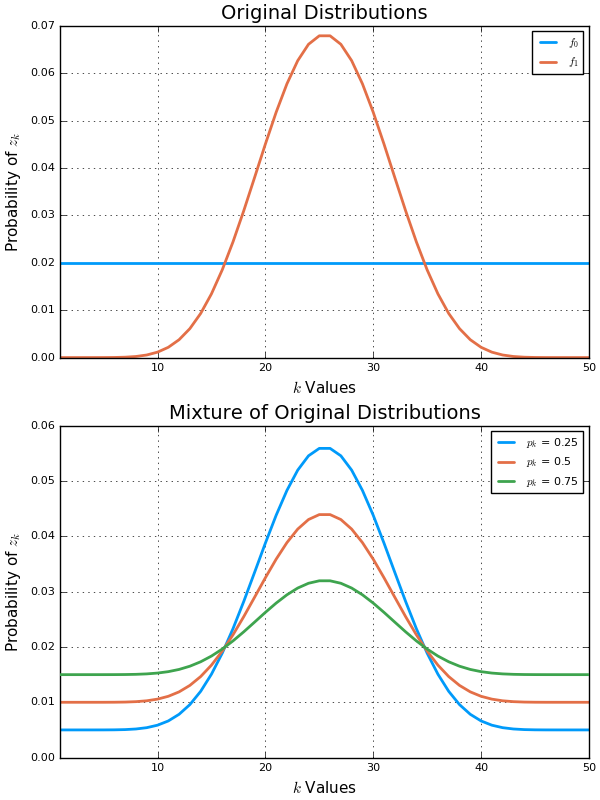

In [3]:
a = plot([f0 f1], 
    xlabel=L"$k$ Values",
    ylabel=L"Probability of $z_k$",
    labels=reshape([L"$f_0$"; L"$f_1$"], 1, 2),
    linewidth=2,
    ylims=[0.;0.07],
    title="Original Distributions")

mix = Array(Float64, 50, 3)
p_k = [0.25; 0.5; 0.75]
labels = Array(String, 3)
for i in 1:3
    mix[:, i] = p_k[i] * f0 + (1 - p_k[i]) * f1
    labels[i] = string(L"$p_k$ = ", p_k[i])
end
    
b = plot(mix, 
    xlabel=L"$k$ Values",
    ylabel=L"Probability of $z_k$",
    labels=reshape(labels, 1, 3),
    linewidth=2,
    ylims=[0.;0.06],
    title="Mixture of Original Distributions")

plot(a, b, layout=(2, 1), size=(600, 800))

### Losses and costs


After observing $z_k, z_{k-1}, \ldots, z_0$, the decision maker chooses among three distinct actions:

* He decides that $x = x_1$ and draws no more $z$'s

* He decides that $x = x_0$ and draws no more $z$'s

* He postpones deciding now and instead chooses to draw a $z_{k+1}$

Associated with these three actions, the decision maker suffers three kinds of losses:

 
* A loss $L_0$ if he decides $x = x_0$ when actually $x=x_1$

* A loss $L_1$ if he decides $x = x_1$ when actually $x=x_0$

* A cost $c$ if he postpones deciding and chooses instead to draw another  $z$ 

For example, suppose that we regard $x=x_0$ as a null hypothesis. Then  

* We can think of $L_1$ as the loss associated with a type I error

* We can think of $L_0$ as the loss associated with a type II error

### A Bellman equation

Let $J_k(p_k)$ be the  total loss for a decision maker who with posterior probability $p_k$ who chooses optimally.

The loss functions $\{J_k(p_k)\}_k$ satisfy the Bellman equations

$$ J_k(p_k) = \min \left[ (1-p_k) L_0, p_k L_1, c + E_{z_{k+1}} \left\{ J_{k+1} (p_{k+1} \right\} \right] $$

where $E_{z_{k+1}}$ denotes a mathematical expectation over the distribution of $z_{k+1}$ and  the minimization is over the three actions, accept $x_0$, accept $x_1$, and postpone deciding and draw 
a $z_{k+1}$.  

Let 

$$ A_k(p_k) = E_{z_{k+1}} \left\{ J_{k+1} \left[\frac{ p_k f_0(z_{k+1})}{ p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1})  } \right] \right\} $$

Then we can write out Bellman equation as

$$ J_k(p_k) = \min \left[ (1-p_k) L_0, p_k L_1, c + A_k(p_k) \right] $$

where $p_k \in [0,1]$.  

Evidently,the optimal decision rule is characterized by two numbers $\alpha_k, \beta_k \in (0,1) \times (0,1)$
that satisfy

$$ (1- p_k) L_0 < \min p_k L_1, c + A_k(p_k)  \textrm { if } p_k \geq \alpha_k  $$

and 

$$ p_k L_1 < \min (1-p_k) L_0,  c + A_k(p_k) \textrm { if } p_k \leq \beta_k $$

The optimal decision rule is then

$$ \textrm { accept } x=x_0 \textrm{ if } p_k \geq \alpha_k \\
   \textrm { accept } x=x_1 \textrm{ if } p_k \leq \beta_k \\
   \textrm { draw another }  z \textrm{ if }  \beta_k \leq p_k \leq \alpha_k $$

### Infinite horizon version

An infinite horizon version of this problem is associated with the limiting Bellman equation 

$$ J(p_k) = \min \left[ (1-p_k) L_0, p_k L_1, c + A(p_k) \right] \quad (*) $$

where

$$ A(p_k) = E_{z_{k+1}} \left\{ J \left[\frac{ p_k f_0(z_{k+1})}{ p_k f_0(z_{k+1}) + (1-p_k) f_1 (z_{k+1})  } \right] \right\} $$

and again the minimization is over the three actions, accept $x_1$, accept $x_0$, and postpone deciding and draw 
a $z_{k+1}$.

Here

  * $ (1-p_k) L_0$ is the expected loss associated with accepting $x_1$ (i.e., the cost of making a type I error)
  
  *  $p_k L_1$ is the expected loss associated with accepting $x_0$ (i.e., the cost of making a type II error)
  
  * $ c + A(p_k)$ is the expected cost associated with drawing one more  $z$


Now the optimal decision rule is characterized by two probabilities $0 < \beta < \alpha < 1$ and 


$$ \textrm { accept } x=x_0 \textrm{ if } p_k \geq \alpha \\
   \textrm { accept } x=x_1 \textrm{ if } p_k \leq \beta \\
   \textrm { draw another }  z \textrm{ if } \beta \leq p_k \leq \alpha $$


  

One sensible approach is to write the three components of the value function that appears on the rights side of the Bellman equation as separate functions.  Later, doing this will help us obey the don't repeat yourself (DRY) rule of coding.  Here goes:

In [4]:
"""
For a given probability return expected loss of choosing model 0
"""
function expect_loss_choose_0(p, L0)
    return (1-p)*L0
end

"""
For a given probability return expected loss of choosing model 1
"""
function expect_loss_choose_1(p, L1)
    return p*L1
end

"""
We will need to be able to evaluate the expectation of our Bellman
equation J. In order to do this, we need the current probability
that model 0 is correct (p), the distributions (f0, f1), and a
function that can evaluate the Bellman equation
"""
function EJ(p, f0, f1, J)
    # Get the current distribution we believe (p*f0 + (1-p)*f1)
    curr_dist = p*f0 + (1-p)*f1
    
    # Get tomorrow's expected distribution through Bayes law
    tp1_dist = clamp((p*f0) ./ (p*f0 + (1-p)*f1), 0, 1)
    
    # Evaluate the expectation
    EJ = dot(curr_dist, J.(tp1_dist))
    
    return EJ
end
    
expect_loss_cont(p, c, f0, f1, J) = c + EJ(p, f0, f1, J);

To approximate the solution of the Bellman equation (\*) above, we can deploy a method known as value function iteration (iterating on the Bellman equation) on a grid of points. Because we are iterating on a grid, the current probability, $p_k$, is restricted to a set number of points. However, in order to evaluate the expectation of the Bellman equation for tomorrow, $A(p_{k})$, we must be able to evaluate at various $p_{k+1}$ which may or may not correspond with points on our grid. The way that we resolve this issue is by using *linear interpolation*. This means to evaluate $J(p)$ where $p$ is not a grid point, we must use two points: first, we use the largest of all the grid points smaller than $p$, and call it $p_i$, and, second, we use the grid point immediately after $p$, named $p_{i+1}$, to approximate the function value in the following manner:

$$ J(p) = J(p_i) + (p - p_i) \frac{J(p_{i+1}) - J(p_i)}{p_{i+1} - p_{i}}$$

In one dimension, you can think of this as simply drawing a line between each pair of points on the grid.

For more information on both linear interpolation and value function iteration methods, see the Quant-Econ [lecture](http://quant-econ.net/py/ifp.html) on the income fluctuation problem.

In [5]:
"""
Evaluates the value function for a given continuation value
function; that is, evaluates

    J(p) = min(pL0, (1-p)L1, c + E[J(p')])

Uses linear interpolation between points
"""
function bellman_operator(pgrid, c, f0, f1, L0, L1, J)
    m = length(pgrid)
    @assert m == length(J)
    
    J_out = zeros(m)
    J_interp = LinInterp(pgrid, J)

    for (p_ind, p) in enumerate(pgrid)
        # Payoff of choosing model 0
        p_c_0 = expect_loss_choose_0(p, L0)
        p_c_1 = expect_loss_choose_1(p, L1)
        p_con = expect_loss_cont(p, c, f0, f1, J_interp)
        
        J_out[p_ind] = min(p_c_0, p_c_1, p_con)
    end
        
    return J_out
end

# To solve
pg = linspace(0, 1, 251)
J1 = compute_fixed_point(x -> bellman_operator(pg, 0.5, f0, f1, 5.0, 5.0, x),
    zeros(length(pg)), err_tol=1e-6, print_skip=5);

Compute iterate 5 with error 0.08552607733051265
Compute iterate 10 with error 0.00038782894418165625
Compute iterate 15 with error 1.6097835344730527e-6
Converged in 16 steps


Now for some gentle criticisms of the preceding code. Although it works fine, by writing the code in terms of  functions, we have to  pass around some things that are constant throughout the problem,  i.e., $c$, $f_0$, $f_1$, $L_0$, and $L_1$. 

Now that we have a working script, let's turn it into types and type-specific methods for each function.  This will allow us to simplify the function calls and make the code more reusable.

So to illustrate a good alternative approach, we write a type that stores all of our parameters for us internally, as well as the model solution, and is used by many of the same functions that we used above.  

In [6]:
"""
This type is used to store the solution to the problem presented 
in the "Wald Friedman" notebook presented on the QuantEcon website.

Solution
----------
J : vector(Float64)
    Discretized value function that solves the Bellman equation
lb : scalar(Real)
    Lower cutoff for continuation decision
ub : scalar(Real)
    Upper cutoff for continuation decision
"""
type WFSolution
    J::Vector{Float64}
    lb::Real
    ub::Real
end

"""
This type is used to solve the problem presented in the "Wald Friedman"
notebook presented on the QuantEcon website.

Parameters
----------
c : scalar(Real)
    Cost of postponing decision
L0 : scalar(Real)
    Cost of choosing model 0 when the truth is model 1
L1 : scalar(Real)
    Cost of choosing model 1 when the truth is model 0
f0 : vector(Float64)
    A finite state probability distribution
f1 : vector(Float64)
    A finite state probability distribution
m : scalar(Int64)
    Number of points to use in function approximation
"""
immutable WaldFriedman
    c::Real
    L0::Real
    L1::Real
    f0::Vector{Float64}
    f1::Vector{Float64}
    m::Int64
    pgrid::LinSpace{Float64}
    sol::WFSolution
end

function WaldFriedman(c, L0, L1, f0, f1; m=25)
    pgrid = linspace(0.0, 1.0, m)

    # Renormalize distributions so nothing is "too" small
    f0 = clamp(f0, 1e-8, 1-1e-8)
    f1 = clamp(f1, 1e-8, 1-1e-8)
    f0 = f0 / sum(f0)
    f1 = f1 / sum(f1)
    J = zeros(m)
    lb = 0.
    ub = 0.
    
    WaldFriedman(c, L0, L1, f0, f1, m, pgrid, WFSolution(J, lb, ub))
end

"""
This function takes a value for the probability with which
the correct model is model 0 and returns the mixed
distribution that corresponds with that belief.
"""
function current_distribution(wf::WaldFriedman, p)
    return p*wf.f0 + (1-p)*wf.f1
end

"""
This function takes a value for p, and a realization of the
random variable and calculates the value for p tomorrow.
"""
function bayes_update_k(wf::WaldFriedman, p, k)
    f0_k = wf.f0[k]
    f1_k = wf.f1[k]

    p_tp1 = p*f0_k / (p*f0_k + (1-p)*f1_k)

    return clamp(p_tp1, 0, 1)
end

"""
This is similar to `bayes_update_k` except it returns a
new value for p for each realization of the random variable
"""
function bayes_update_all(wf::WaldFriedman, p)
    return clamp(p*wf.f0 ./ (p*wf.f0 + (1-p)*wf.f1), 0, 1)
end

"""
For a given probability specify the cost of accepting model 0
"""
function payoff_choose_f0(wf::WaldFriedman, p)
    return (1-p)*wf.L0
end

"""
For a given probability specify the cost of accepting model 1
"""
function payoff_choose_f1(wf::WaldFriedman, p)
    return p*wf.L1
end

"""
This function evaluates the expectation of the value function
at period t+1. It does so by taking the current probability
distribution over outcomes:

    p(z_{k+1}) = p_k f_0(z_{k+1}) + (1-p_k) f_1(z_{k+1})

and evaluating the value function at the possible states
tomorrow J(p_{t+1}) where

    p_{t+1} = p f0 / ( p f0 + (1-p) f1)

Parameters
----------
p : scalar
    The current believed probability that model 0 is the true
    model.
J : function (interpolant)
    The current value function for a decision to continue

Returns
-------
EJ : scalar
    The expected value of the value function tomorrow
"""
function EJ(wf::WaldFriedman, p, J)
    # Pull out information
    f0, f1 = wf.f0, wf.f1

    # Get the current believed distribution and tomorrows possible dists
    # Need to clip to make sure things don't blow up (go to infinity)
    curr_dist = current_distribution(wf, p)
    tp1_dist = bayes_update_all(wf, p)
   
    # Evaluate the expectation
    EJ = dot(curr_dist, J.(tp1_dist))

    return EJ
end

"""
For a given probability distribution and value function give
cost of continuing the search for correct model
"""
function payoff_continue(wf::WaldFriedman, p, J)
    return wf.c + EJ(wf, p, J)
end

"""
Evaluates the value function for a given continuation value
function; that is, evaluates

    J(p) = min( (1-p)L0, pL1, c + E[J(p')])

Uses linear interpolation between points
"""
function bellman_operator(wf::WaldFriedman, J)
    c, L0, L1, f0, f1 = wf.c, wf.L0, wf.L1, wf.f0, wf.f1
    m, pgrid = wf.m, wf.pgrid

    J_out = zeros(m)
    J_interp = LinInterp(pgrid, J)
    
    for (p_ind, p) in enumerate(pgrid)
        # Payoff of choosing model 0
        p_c_0 = payoff_choose_f0(wf, p)
        p_c_1 = payoff_choose_f1(wf, p)
        p_con = payoff_continue(wf, p, J_interp)

        J_out[p_ind] = min(p_c_0, p_c_1, p_con)
    end

    return J_out
end

"""
This function takes a value function and returns the corresponding
cutoffs of where you transition between continue and choosing a
specific model
"""
function find_cutoff_rule(wf::WaldFriedman, J)
    m, pgrid = wf.m, wf.pgrid

    # Evaluate cost at all points on grid for choosing a model
    p_c_0 = payoff_choose_f0(wf, pgrid)
    p_c_1 = payoff_choose_f1(wf, pgrid)

    # The cutoff points can be found by differencing these costs with
    # the Bellman equation (J is always less than or equal to p_c_i)
    lb = pgrid[searchsortedlast(p_c_1 - J, 1e-10)]
    ub = pgrid[searchsortedlast(J - p_c_0, -1e-10)]

    return lb, ub
end

function solve_model(wf; tol=1e-7)
    bell_op(x) = bellman_operator(wf, x)
    J =  compute_fixed_point(bell_op, zeros(wf.m), err_tol=tol, print_skip=5)

    wf.sol.J = J
    wf.sol.lb, wf.sol.ub = find_cutoff_rule(wf, J)
    return J
end

"""
This function takes an initial condition and simulates until it
stops (when a decision is made).
"""
function simulate(wf::WaldFriedman, f; p0=0.5)
    # Check whether vf is computed
    if sumabs(wf.sol.J) < 1e-8
        solve_model(wf)
    end
        
    # Unpack useful info
    lb, ub = wf.sol.lb, wf.sol.ub
    drv = DiscreteRV(f)

    # Initialize a couple useful variables
    decision_made = false
    decision = 0
    p = p0
    t = 0

    while !decision_made
        # Maybe should specify which distribution is correct one so that
        # the draws come from the "right" distribution
        k = draw(drv)[1]
        t = t+1
        p = bayes_update_k(wf, p, k)
        if p < lb
            decision_made = true
            decision = 1
        elseif p > ub
            decision_made = true
            decision = 0
        end
    end
            
    return decision, p, t
end

"""
Uses the distribution f0 as the true data generating
process
"""
function simulate_tdgp_f0(wf::WaldFriedman; p0=0.5)
    decision, p, t = simulate(wf, wf.f0; p0=p0)

    if decision == 0
        correct = true
    else
        correct = false
    end
        
    return correct, p, t
end

"""
Uses the distribution f1 as the true data generating
process
"""
function simulate_tdgp_f1(wf::WaldFriedman; p0=0.5)
    decision, p, t = simulate(wf, wf.f1; p0=p0)

    if decision == 1
        correct = true
    else
        correct = false
    end
        
    return correct, p, t
end

"""
Simulates repeatedly to get distributions of time needed to make a
decision and how often they are correct.
"""
function stopping_dist(wf::WaldFriedman; ndraws=250, tdgp="f0")
    if tdgp=="f0"
        simfunc = simulate_tdgp_f0
    else
        simfunc = simulate_tdgp_f1
    end
        
    # Allocate space
    tdist = Array(Int64, ndraws)
    cdist = Array(Bool, ndraws)

    for i in 1:ndraws
        correct, p, t = simfunc(wf)
        tdist[i] = t
        cdist[i] = correct
    end
        
    return cdist, tdist
end

stopping_dist

Now let's use our types to solve the Bellman equation (*) and check whether it gives the same answer attained above.

In [7]:
wf = WaldFriedman(0.5, 5.0, 5.0, f0, f1; m=251)
J2 = compute_fixed_point(x -> bellman_operator(wf, x), zeros(wf.m), err_tol=1e-6, print_skip=5)

@printf("If this is true then both approaches gave same answer:\n")
print(isapprox(J1, J2; atol=1e-5))

Compute iterate 5 with error 0.0855260926408965
Compute iterate 10 with error 0.0003878288254588469
Compute iterate 15 with error 1.6097831208039537e-6
Converged in 16 steps
If this is true then both approaches gave same answer:
true

### Numerical Example

Now let's specify the two probability distibutions (the ones that we plotted earlier)

* for $f_0$ we'll assume a beta distribution with parameters $a=1, b=1$

* for $f_1$ we'll assume a beta distribution with parameters $a=9, b=9$

The density of a  beta probability distribution with parameters $a$ and $b$ is

$$ f(z; a, b) = \frac{\Gamma(a+b) z^{a-1} (1-z)^{b-1}}{\Gamma(a) \Gamma(b)}$$

where $\Gamma$ is the gamma function 

$$\Gamma(t) = \int_{0}^{\infty} x^{t-1} e^{-x} dx$$


In [8]:
# Choose parameters
c = 1.25
L0 = 27.0
L1 = 27.0

# Choose n points and distributions
m = 251
f0 = pdf(Beta(2.5, 3), linspace(0, 1, m))
f0 = f0 / sum(f0)
f1 = pdf(Beta(3, 2.5), linspace(0, 1, m))
f1 = f1 / sum(f1)  # Make sure sums to 1

# Create an instance of our WaldFriedman class
wf = WaldFriedman(c, L0, L1, f0, f1; m=m);

In [9]:
# Solve and simulate the solution
cdist, tdist = stopping_dist(wf; ndraws=5000)

Compute iterate 5 with error 1.2384971736003685
Compute iterate 10 with error 0.6235689198598084
Compute iterate 15 with error 0.03178165128978527
Compute iterate 20 with error 0.0005980373085616719
Compute iterate 25 with error 1.1172556856564597e-5
Compute iterate 30 with error 2.0872615458245036e-7
Converged in 31 steps


(Bool[true,true,true,false,true,false,false,true,false,true  …  false,false,false,true,false,true,true,true,true,true],[1,1,2,1,1,3,3,1,1,1  …  1,1,1,1,1,1,1,1,1,1])

The value function equals $ p L_1$ for $p \leq \alpha$, and $(1-p )L_0$ for $ p \geq \beta$.
Thus, the slopes of the two linear pieces of the value function are determined by $L_1$ and 
$- L_0$.  

The value function is smooth in the interior region in which the probability assigned to distribution  $f_0$ is in the indecisive region $p \in (\alpha, \beta)$.

The decision maker continues to sample until the probability that he attaches to model $f_0$ falls below $\alpha$ or above $\beta$.

The value function is smooth in the interior region in which the probability assigned to distribution  $f_0$ is in the indecisive region $p \in (\alpha, \beta)$.



Now to have some fun, you can change the cost parameters $L_0, L_1, c$, the parameters of two beta distributions $f_0$ and $f_1$, and the number of points and linear functions $m$ to use in our piece-wise continuous approximation to the value function. You can see the effects on the smoothness of the value function in the  middle range as you increase the numbers of functions in the piecewise linear approximation.  

The function `stopping_dist` draws a number of simulations from $f_0$, computes a distribution of waiting times to making a decision, and displays a histogram of correct and incorrect decisions. (Here the correct decision occurs when $p_k$ eventually exceeds $\beta$).


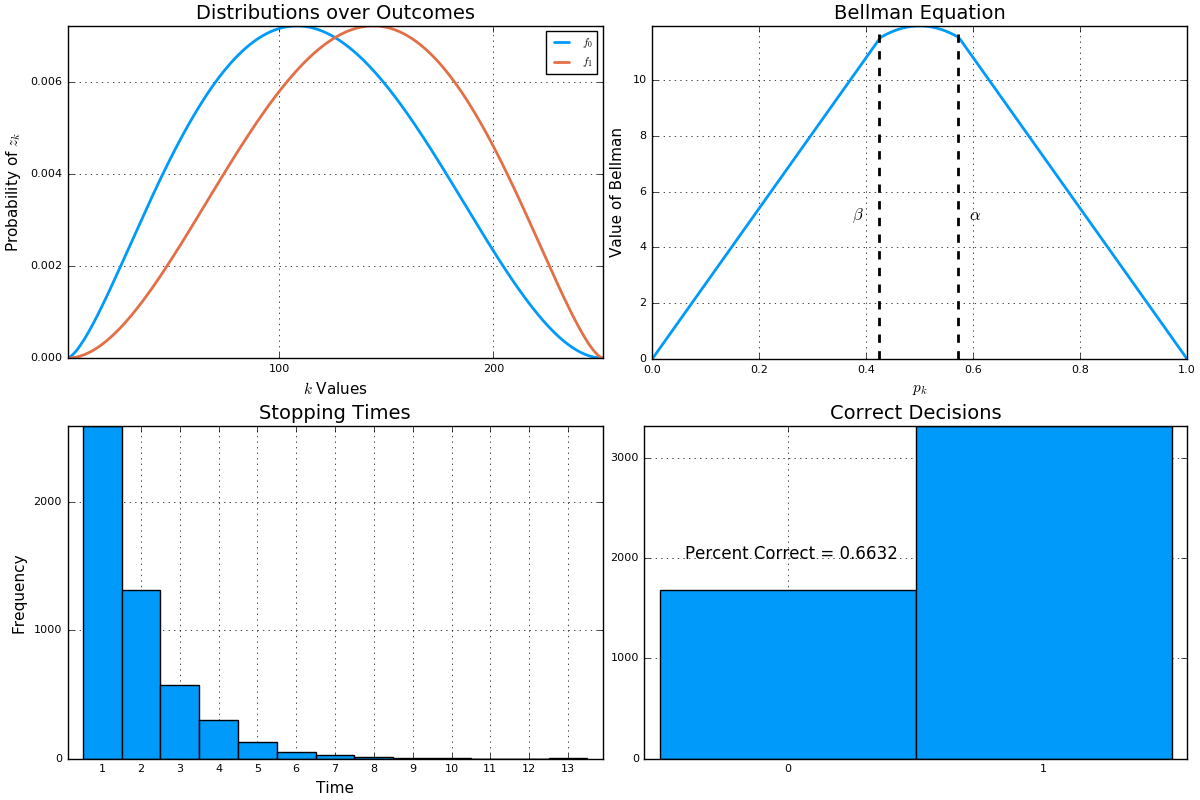

In [10]:
a = plot([f0 f1], 
    xlabel=L"$k$ Values",
    ylabel=L"Probability of $z_k$",
    labels=reshape([L"$f_0$"; L"$f_1$"], 1, 2),
    linewidth=2,
    title="Distributions over Outcomes")

b = plot(wf.pgrid, wf.sol.J, 
    xlabel=L"$p_k$",
    ylabel="Value of Bellman",
    linewidth=2,
    title="Bellman Equation")
    plot!(fill(wf.sol.lb, 2), [minimum(wf.sol.J); maximum(wf.sol.J)],
    linewidth=2, color=:black, linestyle=:dash, label="", ann=(wf.sol.lb-0.05, 5., L"\beta"))
    plot!(fill(wf.sol.ub, 2), [minimum(wf.sol.J); maximum(wf.sol.J)],
    linewidth=2, color=:black, linestyle=:dash, label="", ann=(wf.sol.ub+0.02, 5., L"\alpha"),
    legend=:none)

counts = Array(Int64, maximum(tdist))
for i in 1:maximum(tdist)
    counts[i] = sum(tdist .== i)
end
c = bar(counts,
    xticks=0:1:maximum(tdist),
    xlabel="Time",
    ylabel="Frequency",
    title="Stopping Times",
    legend=:none)

counts = Array(Int64, 2)
for i in 1:2
    counts[i] = sum(cdist .== i-1)
end
d = bar([0; 1],
    counts, 
    xticks=[0; 1],
    title="Correct Decisions", 
    ann=(-.4, 0.6 * sum(cdist), "Percent Correct = $(sum(cdist)/length(cdist))"),
    legend=:none)

plot(a, b, c, d, layout=(2, 2), size=(1200, 800))

### Comparison with Neyman-Pearson formulation

For several reasons, it is useful to describe the theory underlying test that Navy Captain G. S. Schuyler had been told to use and that led him to approach Milton Friedman and Allan Wallis to convey his conjecture that superior practical procedures existed.  Evidently,
the Navy had told Captail Schuyler to use what it knew to be  a state-of-the-art Neyman-Pearson test. 

We'll rely on Abraham Wald's elegant summary of Neyman-Pearson theory.  For our purposes, watch for  there features of the setup:

   * the assumption of a *fixed *sample size $n$
   
   * the application of  laws of large numbers, conditioned on alternative probability models, to interpret the probabilities $\alpha$ and $\beta$ defined in the Neyman-Pearson theory.
   
Recall that in the sequential analytic formulation above, that

  * The sample size $n$ is not fixed but rather an object to be chosen; technically $n$ is a random variable. 
  
  * The parameters $\alpha$ and $\beta$ characterize cut-off rules used to determine $n$ as a random variable.
  
  * Laws of large numbers make no appearances in the sequential construction.

In chapter 1 of **Sequential Analysis** Abraham Wald summarizes the Neyman-Pearson approach to hypothesis testing.

Wald frames the problem as making a decision about a probability distribution that is partially known. (You have to assume that *something* is already known in order to state a well posed problem.  Usually, *something* means *a lot*.)

By restricting what is unknown, Wald uses the following simple structure to illustrate the main ideas.

   * a decision maker wants to decide which of two distributions $f_0$,  $f_1$ govern an i.i.d. random variable $z$
   
   * The null hypothesis $H_0$ is the statement that $f_0$ governs the data.
   
   * The alternative hypothesis $H_1$ is the statement that $f_1$ governs the data. 
   
   * The problem is to devise and analyze a test of hypthothesis $H_0$ against the alternative hypothesis $H_1$ on the basis of a sample of a fixed number $n$ independent observations $z_1, z_2, \ldots, z_n$ of the random variable $z$.  
   
To quote Abraham Wald,

  * *A test procedure leading to the acceptance or rejection of the hypothesis in question is simply a rule specifying, for each possible sample of size $n$, whether the hypothesis should be accepted or rejected on the basis of the sample. This may also be expressed as follows: A test procedure is simply a subdivision of the totality of all possibsle samples of size $n$ into two mutually exclusive parts, say part 1 and part 2, together with the application of the rule that the hypothesis be accepted if the observed sample is contained in part 2.  Part 1 is also called the critical region.  Since part 2 is the totality of all samples of size 2 which are not included in part 1, part 2 is uniquely determined by part 1.  Thus, choosing a test procedure is equivalent to determining a critical region.* 
  
Let's listen to Wald longer:

  * *As a basis for choosing among critical regions the following considerations have been advanced by Neyman and Pearson: In accepting or rejecting $H_0$ we may commit errors of two kinds. We commit an error of the first kind if we reject $H_0$ when it is true; we commit an error of the second kind if we accept $H_0$ whe $H_1$ is true.  After a particular critical region $W$ has been chosen, the probability of committing an error of the first kind, as well as the probability of committing an error of the second kind is uniquely determined.  The probability of committing an error of the first kind is equal to the probability, determined by the assumption that $H_0$ is true, that the observed sample will be included in the critical region $W$.  The probability of committing an error of the second kind is equal to the probability, determined on the assumption that $H_1$ is true, that the probability will fall outside the critical region $W$.  For any given critical region $W$ we shall denote the probability of an error of the first kind by $\alpha$ and the probability of an error of the second kind by $\beta$.*


Let's listen carefully to how Wald applies a law of large numbers to interpret $\alpha$ and $\beta$:

  * *The probabilities $\alpha$ and $\beta$ have the following important practical interpretation: Suppose that we draw a large number of samples of size $n$.  Let $M$ be the number of such samples drawn.  Suppose that for each of these $M$ samples we reject $H_0$ if the sample is included in $W$ and accept $H_0$ if the sample lies outside $W$.  In this way we make $M$ statements of rejection or acceptance.  Some of these statements will in general be wrong.  If $H_0$ is true and if $M$ is large, the probability is nearly $1$ (i.e., it is practically certain) that the proportion of wrong statements (i.e., the number of wrong statements divided by $M$) will be approximately $\alpha$.  If $H_1$ is true, the probability is nearly $1$ that the proportion of wrong statements will be approximately $\beta$.  Thus, we can say that in the long run [ here Wald applies a law of large numbers by driving $M \rightarrow \infty$ (our comment, not Wald's) ] the proportion of wrong statements will be $\alpha$ if $H_0$is true and $\beta $ if $H_1$ is true.*

The quantity $\alpha$ is called the *size* of the critical region, and the quantity $1-\beta$ is called the *power* of the critical region.

Wald notes that 

  * *one critical region $W$ is more desirable than another if it has smaller values of $\alpha$ and $\beta$.  Although either $\alpha$ or $\beta$ can be made arbitrarily small by a proper choice of the critical region $W$, it is possible to make both $\alpha$ and $\beta$ arbitrarily small for a fixed value of $n$, i.e., a fixed sample size.*


Wald summarizes Neyman and Pearson's setup as follows:

 * *Neyman and Pearson show that a region consisting of all samples $(z_1, z_2, \ldots, z_n)$ which satisfy the inequality 
 $$\frac{ f_1(z_1) \cdots f_1(z_n)}{f_0(z_1) \cdots f_1(z_n)} \geq k $$ is a most powerful critical region for testing the hypothesis $H_0$ against the alternative hypothesis $H_1$. The term $k$ on the right side is a constant chosen so that the region will have the required size $\alpha$.*
 
Wald goes on to discuss Neyman and Pearson's concept of *uniformly most powerful* test. 


Here is how Wald introduces the notion of a sequential test
•A rule is given for making one of the following three decisions at any stage of the experiment (at the m th trial for each integral value of m ): (1) to accept the hypothesis H , (2) to reject the hypothesis H , (3) to continue the experiment by making an additional observation. Thus, such a test procedure is carried out sequentially. On the basis of the first observation one of the aforementioned decisions is made. If the first or second decision is made, the process is terminated. If the third decision is made, a second trial is performed. Again, on the basis of the first two observations one of the three decisions is made. If the third decision is made, a third trial is performed, and so on. The process is continued until either the first or the second decisions is made. The number n  of observations required by such a test procedure is a random variable, since the value of n  depends on the outcome of the observations.
